In [ ]:
#https://github.com/cvg/DeepLSD

import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

In [ ]:

# Model config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': 'strict',  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

[ WARN:0@8182.310] global loadsave.cpp:241 findDecoder imread_('../assets/images/fail_3'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

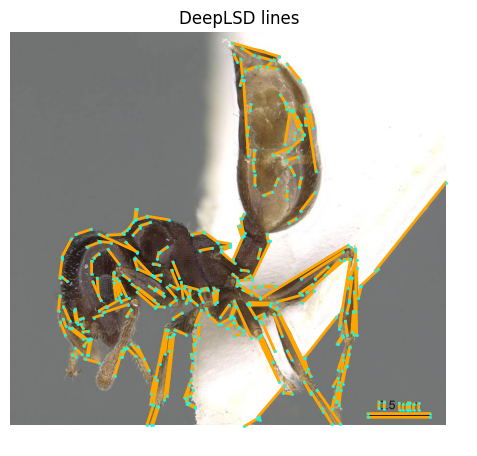

In [21]:
# Load an image
img = cv2.imread('../assets/images/example_2.jpg')[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))
pred_line_scalebar, i = detect_scalebar('../assets/images/fail_3', 0.5)
p = pred_lines[i]
p = np.expand_dims(p, axis=0)
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([p], indices=range(1))



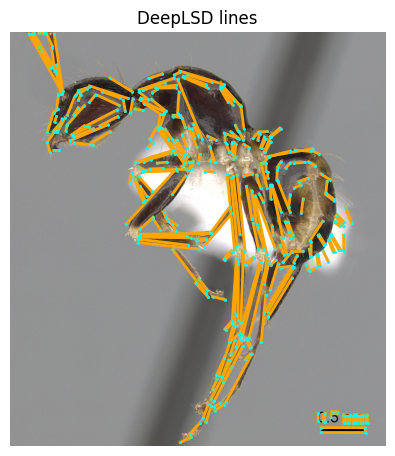

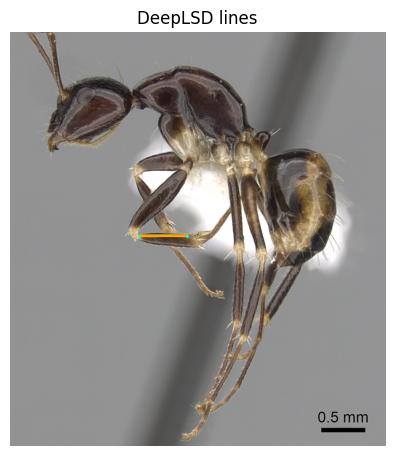

In [ ]:
from PIL import Image, ImageDraw, ImageFilter

def detect_scalebar(path_image, thresh, isPlot=False):
    """
    Detects all the line segments using DeepLSD algorithm

    Args:
        path_image (str): path of the image to analyse
        thresh (float): angle threshold to determine if a segment is horizontal or not: it must in between 180+- thresh or 0+-thresh degrees
        isPlot (bool): boolean to plot or not the image

    Returns:
        pred_SB (numpy array): 4 elements numpy array containing the [x1, y1, x2, y2] coordinates of the detected bar
        indice_scalebar(int): indice of the line segment that is considered to be the scale bar
    """
    
    # Load an image
    img = cv2.imread(path_image)[:, :, ::-1]
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    # Detect (and optionally refine) the lines
    inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
    with torch.no_grad():
        out = net(inputs)
        
        pred_lines = out['lines'][0]

    max = 0

    s = pred_lines.shape
    for i in range(s[0]):
        angle_radians = np.arctan2(pred_lines[i][0],pred_lines[i][1])
        # Convert to degrees
        angle_degrees = np.degrees(angle_radians)
        if abs(angle_degrees) < thresh or abs(angle_degrees) > 180-thresh:
            v = pred_lines[i][1] - pred_lines[i][0] 
            distance = np.linalg.norm(v)
            if distance > max:
                max = distance
                pred_SB = pred_lines[i]
                indice_scalebar = i

    x1 = np.min([pred_SB[0][0],pred_SB[1][0]])
    y1 = np.mean([pred_SB[0][1],pred_SB[1][1]])

    x2 = np.max([pred_SB[0][0],pred_SB[1][0]])
    y2 = y1

    pred_SB =np.array([x1, y1, x2, y2])
    if isPlot:  
        shape = [(x1, y1),(x2, y2+5)] 
        Im_color = Image.open(path_image)
        img1 = ImageDraw.Draw(Im_color) 
        img1.rectangle(shape, fill="green", outline ="green")
        Im_color.show() 

    return pred_SB, indice_scalebar


[251.99503 396.8906  344.99945 396.8906 ]


In [ ]:
import os
import csv

path_images = "/Users/vivien.gaillet/Library/CloudStorage/OneDrive-NordAngliaEducation/NAE - Files/Downloads/original/"
path_name_validation_set = "/Users/vivien.gaillet/Library/CloudStorage/OneDrive-NordAngliaEducation/CS_433_Machine_Learning/names_images.txt"
path_directory_save = "/Users/vivien.gaillet/Library/CloudStorage/OneDrive-NordAngliaEducation/CS_433_Machine_Learning/bar_detection_DeepLSD_results/"
name_result_csv = "result.csv"

           
with open(path_name_validation_set, "r") as file:
        for line in file:
            count = count + 1

            print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
            print(count)
            name_file = line.strip()
            print(path_images+name_file)

            scalebar, i = detect_scalebar(path_images+name_file, 0.5, False)
            print(scalebar)

            
            Im_color = Image.open(path_images+name_file)
            img1 = ImageDraw.Draw(Im_color) 
            t = 10
            shape = [(scalebar[0], scalebar[1]-t),(scalebar[0]+t, scalebar[1])] 
            img1.rectangle(shape, fill="red", outline ="red")

            shape = [(scalebar[2]-t, scalebar[3]+10),(scalebar[2], scalebar[3]+10+t)] 
            img1.rectangle(shape, fill="red", outline ="red")

            Im_color.save(path_directory_save + "scale_bar_" + name_file)
            Im_color.close() 
            
            with open(path_directory_save + name_result_csv, 'a') as f:
                writer = csv.writer(f)
                writer.writerow(scalebar)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
1
/Users/vivien.gaillet/Library/CloudStorage/OneDrive-NordAngliaEducation/NAE - Files/Downloads/original/anic32-900190-1_p_1.jpg
[213.99808 588.8345  460.00162 588.8345 ]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
2
/Users/vivien.gaillet/Library/CloudStorage/OneDrive-NordAngliaEducation/NAE - Files/Downloads/original/antweb1008066_p_1.jpg
[ 920.99927  781.77    1087.9993   781.77   ]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
3
/Users/vivien.gaillet/Library/CloudStorage/OneDrive-NordAngliaEducation/NAE - Files/Downloads/original/antweb1008086_p_1.jpg
[1073.9991  779.5979 1295.999   779.5979]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
4
/Users/vivien.gaillet/Library/CloudStorage/OneDrive-NordAngliaEducation/NAE - Files/Downloads/original/antweb1038001_p_1.jpg
[ 852.00256  771.68774 1009.0021   771.68774]
- - - 